In [40]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

from dotenv import load_dotenv

from langgraph.graph import StateGraph,START,END

from pydantic import BaseModel,Field
from typing import TypedDict,Annotated

In [41]:
load_dotenv()

True

In [42]:
model=ChatGroq(model="llama-3.3-70b-versatile",temperature=0)

In [43]:
class StateSchema(TypedDict):

    question:str
    max_iteration:int

    sql:str
    confidence_score:float
    feedback:str

    iteration:int

In [44]:
class SQLSchema(BaseModel):
    sql:Annotated[str,Field(...,description="SQL query as per the question")]
    confidence_score:Annotated[float,Field(...,description="Confidence score in a sclae of 0 to 1",ge=0,le=1)]
    feedback:Annotated[str,Field(...,description="Feedback in a line about the query or if the question was not understood")]


In [45]:
model2=model.with_structured_output(SQLSchema,method="json_mode")

In [46]:
graph=StateGraph(StateSchema)

In [ ]:
def sql_generator(state:StateSchema)->StateSchema:
    sys_inst="""You are an SQL expert. Given a schema and a natural question you will provide three output in ONLY a vlaid JSON object:
    {{
    "sql":"The optimized SQL query for the question",
    "confidence_score":"A float number between 0 to 1 regarding how confident you are if the query will work.",
    "feedback":"Any feedback about the query or the question"
    }}"""
    prompt=ChatPromptTemplate.from_messages([
        ("system",sys_inst),
        ("human","""
        ----------Rule-----------
         1. You must only return SELECT statement
         2. DO not add any extra explanation,comments or markdowns
         3. Use only the schema that is provided.
         Question:{question}""")])
    
    chain=prompt | model2
    response=chain.invoke({"question":state["question"],"max_iteration":state["max_iteration"]})

    return {
        "sql":response.sql,
        "confidence_score":response.confidence_score,
        "feedback":response.feedback
    }

In [48]:
graph.add_node('sql_generator',sql_generator)

graph.add_edge(START,'sql_generator')
graph.add_edge('sql_generator',END)

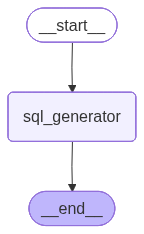

In [49]:
workflow=graph.compile()
workflow

In [50]:
result=workflow.invoke({
    "question":"Given a database name student consisting of student_name,age,marks,gender give me the name of the student with highest marks",
    "max_iteration":2
})
result['sql']

'SELECT student_name FROM student ORDER BY marks DESC LIMIT 1'

In [51]:
result['confidence_score']

0.9

In [52]:
result['feedback']

'Assuming there are no duplicate highest marks, this query will return one student name. If there are duplicates, it will return one of them.'